In [11]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from torch.utils.data import Dataset, DataLoader
#import data_layer_cross 
import statistics
import seaborn as sns
import tensorflow as tf

In [12]:
class SimpleDenseModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleDenseModel, self).__init__()
        self.dense1 = nn.Linear(input_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = self.dense2(x)
        return x
def load_tf_weights_to_pytorch(checkpoint_path, input_size, hidden_size, output_size):
    # Use compatibility mode to access TensorFlow 1.x functionality
    tf.compat.v1.disable_eager_execution()

    # Create a NewCheckpointReader to read the TensorFlow checkpoint
    reader = tf.compat.v1.train.NewCheckpointReader(checkpoint_path)

    # Extract weights and biases from the checkpoint
    dense1_weights = reader.get_tensor('Model_Layer/NN_Layer/dense_layer_0/dense/kernel')
    dense1_bias = reader.get_tensor('Model_Layer/NN_Layer/dense_layer_0/dense/bias')
    dense2_weights = reader.get_tensor('Model_Layer/NN_Layer/last_dense_layer/dense/kernel')
    dense2_bias = reader.get_tensor('Model_Layer/NN_Layer/last_dense_layer/dense/bias')

    # Construct the PyTorch model with similar architecture
    model = SimpleDenseModel(input_size, hidden_size, output_size)
    
    # Load the weights and biases into the PyTorch model
    with torch.no_grad():
        model.dense1.weight = nn.Parameter(torch.tensor(dense1_weights.T))
        model.dense1.bias = nn.Parameter(torch.tensor(dense1_bias))
        model.dense2.weight = nn.Parameter(torch.tensor(dense2_weights.T))
        model.dense2.bias = nn.Parameter(torch.tensor(dense2_bias))

    return model

In [13]:
#read input data 
datapath = "CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz"
data = np.load(datapath)
data, data['data'].shape, data['variable']

(NpzFile 'CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz' with keys: date, variable, wficn, data,
 (469, 3271, 61),
 array(['FC2Y', 'Beta', 'OA', 'CF', 'Variance', 'BEME', 'CTO', 'RNA', 'NI',
        'r12_2', 'CF2P', 'r36_13', 'ROA', 'r2_1', 'Resid_Var', 'DPI2A',
        'IdioVol', 'AC', 'PM', 'ATO', 'D2A', 'SUV', 'SGA2S', 'r12_7',
        'PCM', 'LT_Rev', 'D2P', 'Rel2High', 'LTurnover', 'ROE', 'MktBeta',
        'Investment', 'Lev', 'LME', 'E2P', 'ST_Rev', 'Spread', 'Q', 'A2ME',
        'NOA', 'C', 'OP', 'S2P', 'OL', 'AT', 'PROF', 'ages', 'flow',
        'exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no',
        'Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1',
        'F_r12_2', 'sentiment'], dtype='<U12'))

In [14]:
#calculate mean for the macro-vairbale
sentiment = data['data'][:,:,-1]
sentiment_list = sentiment.flatten()
sentiment_mean = np.mean(sentiment_list)
sentiment_mean
def replace_outliers(array, upper, lower, replace=0):
    # Create a mask for values that are less than lower or greater than upper
    #by default replace with 0 
    mask = (array < lower) | (array > upper)
    array[mask] = replace
    return array
def sanitize_input_3d(input_features, mean=0, mean_macro=sentiment_mean):
    #expected input: [time, funds, variables]
    other_features = input_features[:,:, :-1]
    macro_features = input_features[:,:, -1:]
    other_features = replace_outliers(other_features, 0.5, -0.5, mean)
    macro_features= replace_outliers(macro_features, 90, -90, mean_macro)
    features_sanitized = np.concatenate((other_features, macro_features), axis=2)
    return features_sanitized
def get_mean_elementwise(tensor_list):
    stacked_tensors = torch.stack(tensor_list)
    mean_tensor = torch.mean(stacked_tensors, dim=0)
    return mean_tensor

In [15]:
train_fold_list = []
root ='Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/output_RF/chronological_order/' 
for i in range(1, 9):
    one_train_fold = []
    for j in range(3):
        path = root + f'Train_fold_{i}/fullnew46591640.950.00.0010.01naturalTestorder{j}/model-best'
        one_train_fold.append(path)
    train_fold_list.append(one_train_fold)

In [16]:
sampling_folds = np.load('Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/sampling_folds/chronological_order_folds.npy', allow_pickle=True)
len(sampling_folds),sampling_folds[0]

(3,
 array([array([156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
               169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
               182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
               195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
               208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
               221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
               234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
               247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
               260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
               273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
               286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
               299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
               312, 313, 314, 315, 3

In [17]:
def get_valid_label_mask_month(labels,lower=-1, upper=1):
    #[funds,]
    valid_rows= (labels >= lower) & (labels <= upper)
    return valid_rows
def sort_fund(timestep_predictions):
  #input(fund_returns) of size (3271, 1) -->this is assumed to be the output of the (trained) model at one timestep
  #function to sort fund in deciles based on their predicted abnormal return for the next month
  fund_data = pd.DataFrame({'fund_id': np.arange(len(timestep_predictions)), 'predicted_abnormal_return': timestep_predictions})
  fund_data['rank'] = fund_data['predicted_abnormal_return'].rank(method='first', ascending=False)
  fund_data['decile'] = pd.qcut(fund_data['rank'], 10, labels=False) + 1
  return fund_data #dataframe with deciles ranks 

def select_decile(fund_data, decile):
    #get indices of all funds within the same decile 
    if decile < 1 or decile > 10:
        raise ValueError("Decile should be between 1 and 10.")
    selected_funds = fund_data[fund_data['decile'] == decile]['fund_id'].values
    return selected_funds

def equal_weight(month_returns):
    #given abnormal returns of the month, return the evenly weighted return 
    #print(torch.mean(month_returns))
    return torch.mean(month_returns)
def plot_returns(abnormal_returns_list, labels, cumulative=False):
    #plot abnormal returns
    #abnormal returns is a list of dictionaries {timestep-->abnormal return}
    #labels is a list of labels (corresponding to each decile)
    #cumulative --> whether to use cumulative return 
    if len(abnormal_returns_list) != len(labels):
        raise ValueError("returns list and labels should match in dimension")
    for i in range (len(abnormal_returns_list)):
        #if i==0:
        #    continue
        timesteps = range(len(abnormal_returns_list[i])+1)
        abnormal_returns = abnormal_returns_list[i]
        abnormal_returns.insert(0, 0) #start with 0 
        if cumulative:
            cumulative_returns = []
            cumulative_log_return_sum  = 0
            for ar in abnormal_returns:
                if torch.is_tensor(ar) and torch.isnan(ar):
                    ar =  0
                cumulative_log_return_sum += (np.log(ar + 1))
                # Calculate the cumulative abnormal return at this timestep
                cumulative_returns.append(np.exp(cumulative_log_return_sum)-1)
            plt.plot(timesteps, cumulative_returns, label=labels[i])
        else:
            plt.plot(timesteps, abnormal_returns)
        #print(len(timesteps), len(cumulative_returns))
    plt.xlabel('Time')
    plt.ylabel('Cumulative Abnormal Return')
    plt.title('Cumulative Abnormal Returns Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
#plot_returns(all_timestep_return, labels, cumulative=True)

In [18]:
all_outputs = []
indexes = range (47, 61)
for checkpoint_list in train_fold_list:
    model_list = []
    input_size = 14
    hidden_size = 64
    output_size = 1
    for checkpoint in checkpoint_list:
        pytorch_model = load_tf_weights_to_pytorch(checkpoint, input_size, hidden_size, output_size)
        model_list.append(pytorch_model)
    inputs_test = torch.tensor(sanitize_input_3d(data['data'][:,:,indexes]), dtype=torch.float32)
    output_list = []
    for i in range (3):
        [train_idx_list, valid_idx_list, test_idx_list] = sampling_folds[i]
        #print(test_idx_list)
        inputs_test = torch.tensor(sanitize_input_3d(data['data'][test_idx_list][:,:,indexes]), dtype=torch.float32)
        curr_model = model_list[i]
        output_list.append(curr_model(inputs_test))
    output = torch.cat(output_list, dim=0)
    all_outputs.append(output)

In [19]:
outputs = get_mean_elementwise(all_outputs)
outputs.shape

torch.Size([469, 3271, 1])

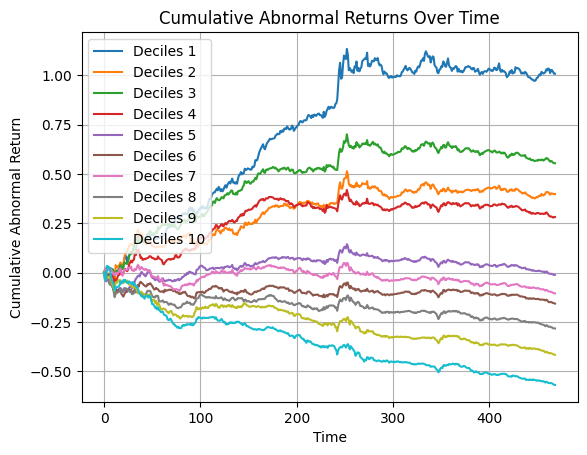

In [21]:
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
timesteps = 468
for i in range (0, timesteps):
    #sort funds based on model prediction
    timestep_pred = outputs[i,:,0] #take predictions of teh specific timestep
    timestep_label = all_labels[i,:,0] #take labels of the specific timestep 
    mask = get_valid_label_mask_month(timestep_label)
    timestep_pred_valid = timestep_pred[mask]
    timestep_label_valid = timestep_label[mask]
    fund_data = sort_fund(timestep_pred_valid.detach().numpy())
    for j in range (1, 11):
        decile_ind = select_decile(fund_data, j)
        decile = torch.tensor(timestep_label_valid)[decile_ind] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        if return_month.isnan():
            print("time", i)
        exec(f'timestep_return_{j}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)

In [23]:
[0]+[3,4]


[0, 3, 4]